In [47]:
runfile('C:/Users/we609/Desktop/cs 4762/project/10K/data_preprocess.py', wdir='C:/Users/we609/Desktop/cs 4762/project/10K')

In [172]:
import numpy as np # numpy for making arrays and doing math on them
import pandas as pd # pandas for importing spreadsheet data and manipulating it
import scipy as sp # scipy for solving equations
import matplotlib as mpl # matplotlib for graphing
import matplotlib.pyplot as plt # the pyplot functions from mathplotlib as plt
import math # math for things like constants (e or pi) and some simple math
import random
import numpy as np
import warnings
import seaborn as sns
import matplotlib
import matplotlib.pylab as pylab
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'
         }
pylab.rcParams.update(params)
import matplotlib.ticker as mticker  
#set the style
sns.set_style("whitegrid")

#suppress warnings
warnings.filterwarnings('ignore')

In [50]:
peak = pd.read_csv('normalize_peak.csv')
expression = pd.read_csv('normalize_expression_level.csv')

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = sample_split(expression,peak,11898)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [9519] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


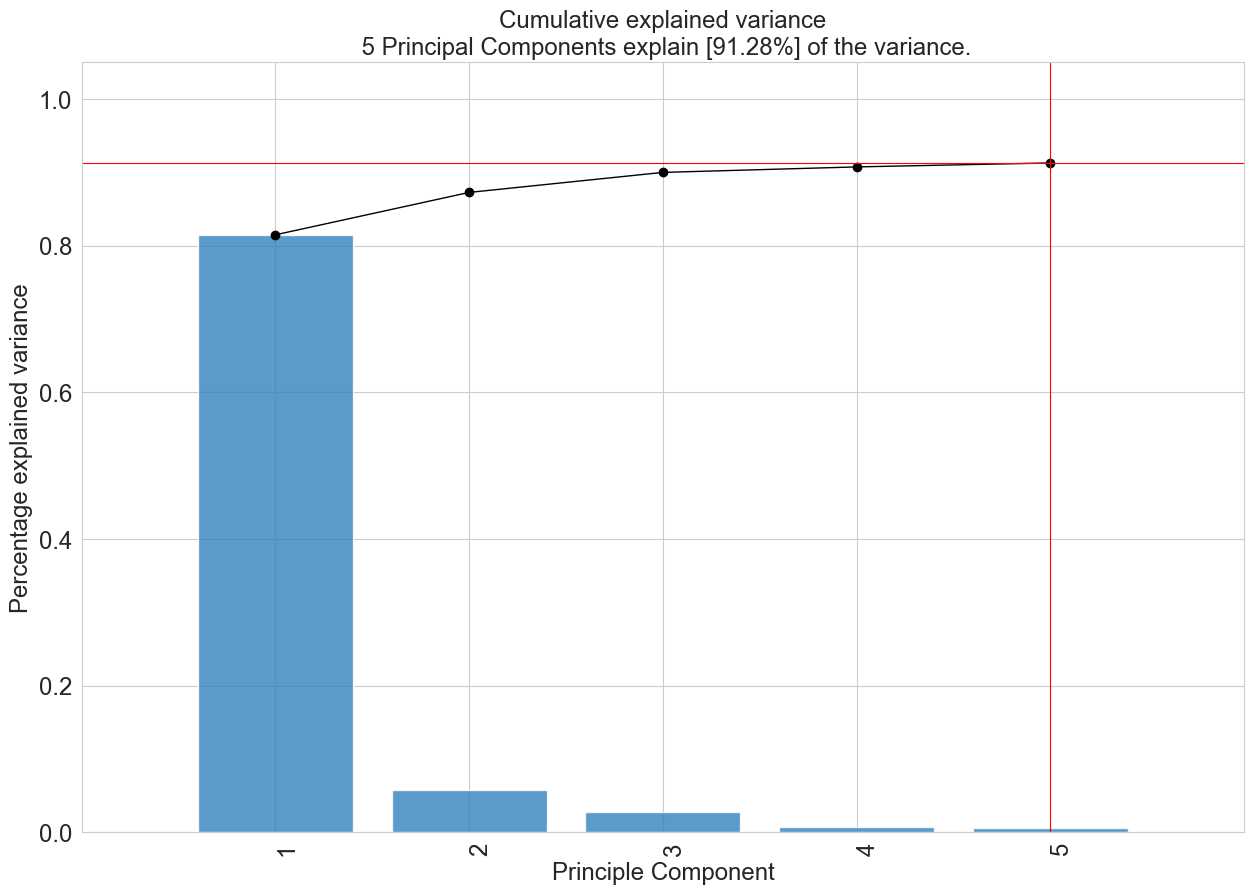

Finished 1000
Finished 2000
Finished 3000
Finished 4000
Finished 5000
Finished 6000
Finished 7000
Finished 8000
Finished 9000


<Figure size 1500x500 with 0 Axes>

In [6]:
X_train_smoothed = aggregate_smooth_function(y_train, X_train, components = 5,k= 30, fig_name = 'PCA_result.png')

In [7]:
X_train_smoothed.to_csv(f'normalized_KSmooth_peak.csv', index=False)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [1190] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


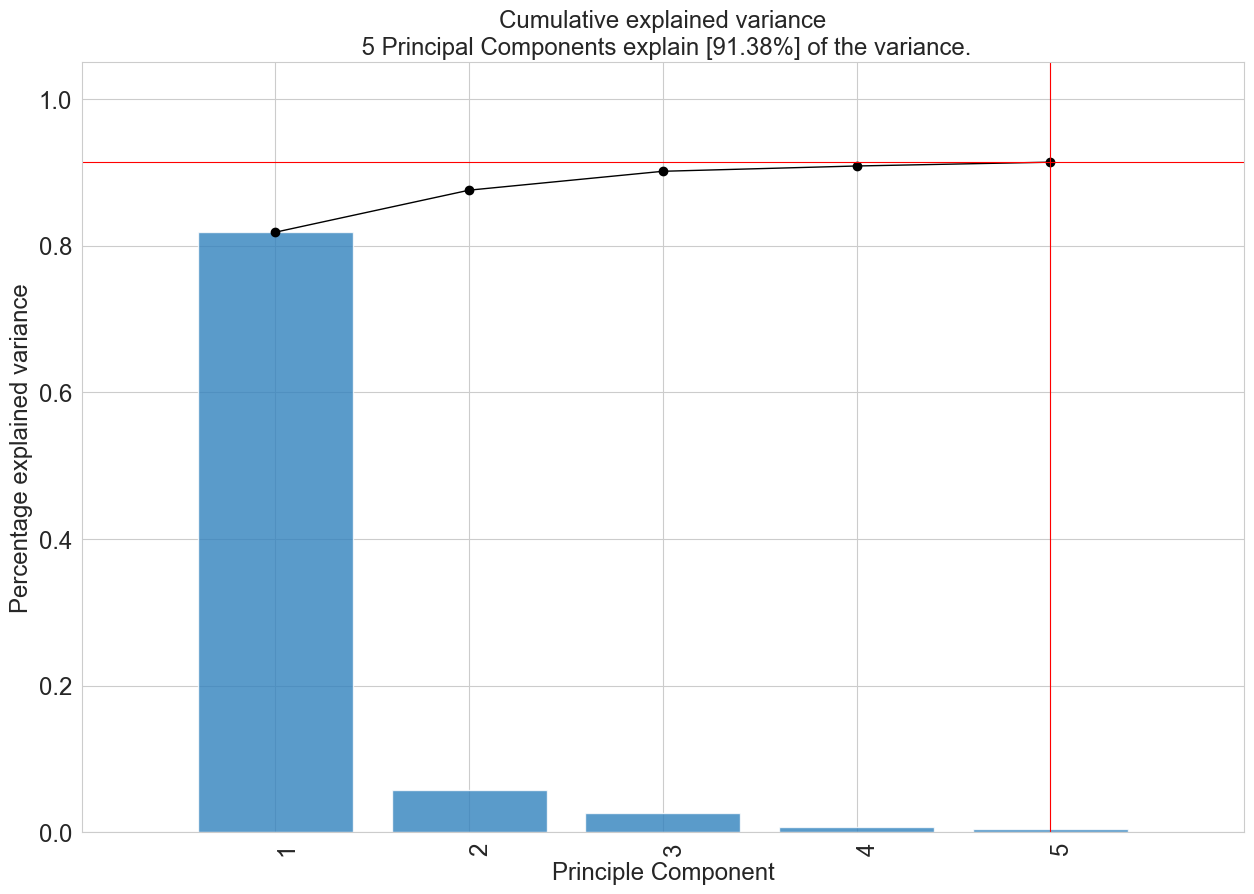

Finished 1000
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [1189] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


<Figure size 1500x500 with 0 Axes>

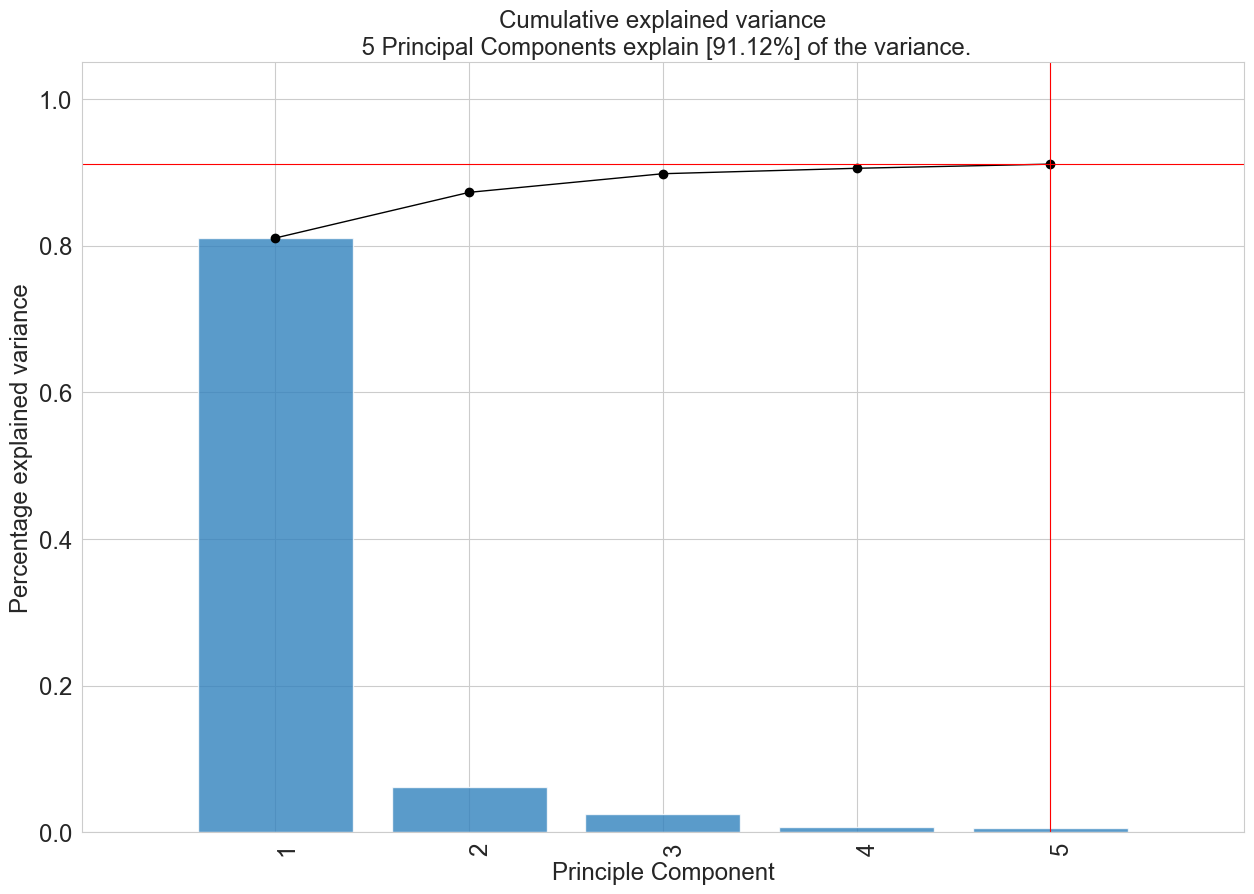

Finished 1000


<Figure size 1500x500 with 0 Axes>

In [8]:
X_val_smoothed = aggregate_smooth_function(y_val, X_val, components = 5,k= 30, fig_name = 'PCA_result.png')
X_test_smoothed = aggregate_smooth_function(y_test, X_test, components = 5,k= 30, fig_name = 'PCA_result.png')


In [31]:
#X_train, X_val, X_test, y_train, y_val, y_test

In [18]:
# round up to reduce computation cost
X_train_smoothed = X_train_smoothed.round(4)
X_val_smoothed = X_val_smoothed.round(4)
X_test_smoothed = X_test_smoothed.round(4)

In [55]:
#calculation ridge for smoothed X_train 
R_2_smooth_ridge = []
possibility_smooth_ridge = []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
peak_count = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    peak_count += [X_train_i.shape[1]]
    if X_train_i.shape[1]== 0:
        continue
        
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6):#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_ridge += [R**2]
        possibility_smooth_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]


In [56]:
len(R_2_smooth_ridge)

3164

In [57]:
sum(R_2_smooth_ridge)/len(R_2_smooth_ridge)


0.02400574036571358

In [58]:
#calculate lasso for smoothed X_train
R_2_smooth_lasso = []
possibility_smooth_lasso = []
All_beta_smooth_lasso = []
RMSE_values_smooth_lasso = []
current_val = 0
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if X_train_i.shape[1]== 0:
        continue
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        current_val = [y_test_i, pred_test]
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_lasso += [R**2]
        possibility_smooth_lasso += [p]
        All_beta_smooth_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_lasso += [RMSE]



In [61]:
sum(R_2_smooth_lasso)/len(R_2_smooth_lasso)


0.024542708510895832

In [59]:
#calculation ridge for X_train
R_2_ridge = []
possibility_ridge = []
All_beta_ridge = []
RMSE_values_ridge = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if X_train_i.shape[1]== 0:
        continue
        
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_ridge += [R**2]
        possibility_ridge += [p]
        All_beta_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_ridge += [RMSE]

In [63]:
len(R_2_ridge)

3135

In [64]:
#calculation lasso for X_train
R_2_lasso = []
possibility_lasso = []
All_beta_lasso = []
RMSE_values_lasso = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if X_train_i.shape[1]== 0:
        continue
        
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6):#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_lasso += [R**2]
        possibility_lasso += [p]
        All_beta_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_lasso += [RMSE]


In [66]:
R_2_smooth_test_ridge = []
possibility_smooth_test_ridge= []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
peak_count = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val_smoothed,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test_smoothed,5000000)
    peak_count += [X_train_i.shape[1]]
    if X_train_i.shape[1]== 0:
        continue
        
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_test_ridge += [R**2]
        
        possibility_smooth_test_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]

In [77]:
temp_df_rows = []
test_smooth = []
for i in R_2_lasso:
    temp_df_rows += [['Lasso', i, 'Z-score']]
for i in R_2_ridge:
    temp_df_rows += [['Ridge', i, 'Z-score']]
for i in R_2_smooth_ridge:
    temp_df_rows += [['Ridge_K-nearest_smooth', i, 'Z-score']]
    test_smooth += [['Ridge_Z-score_normalization', i , False]]
for i in R_2_smooth_lasso:
    temp_df_rows += [['Lasso_K-nearest_smooth', i, 'Z-score']]
for i in R_2_smooth_test_ridge:
    test_smooth += [['Ridge_Z-score_normalization', i , True]]

temp_df = pd.DataFrame(temp_df_rows, columns=['Models', 'R^2', 'Normalization'])

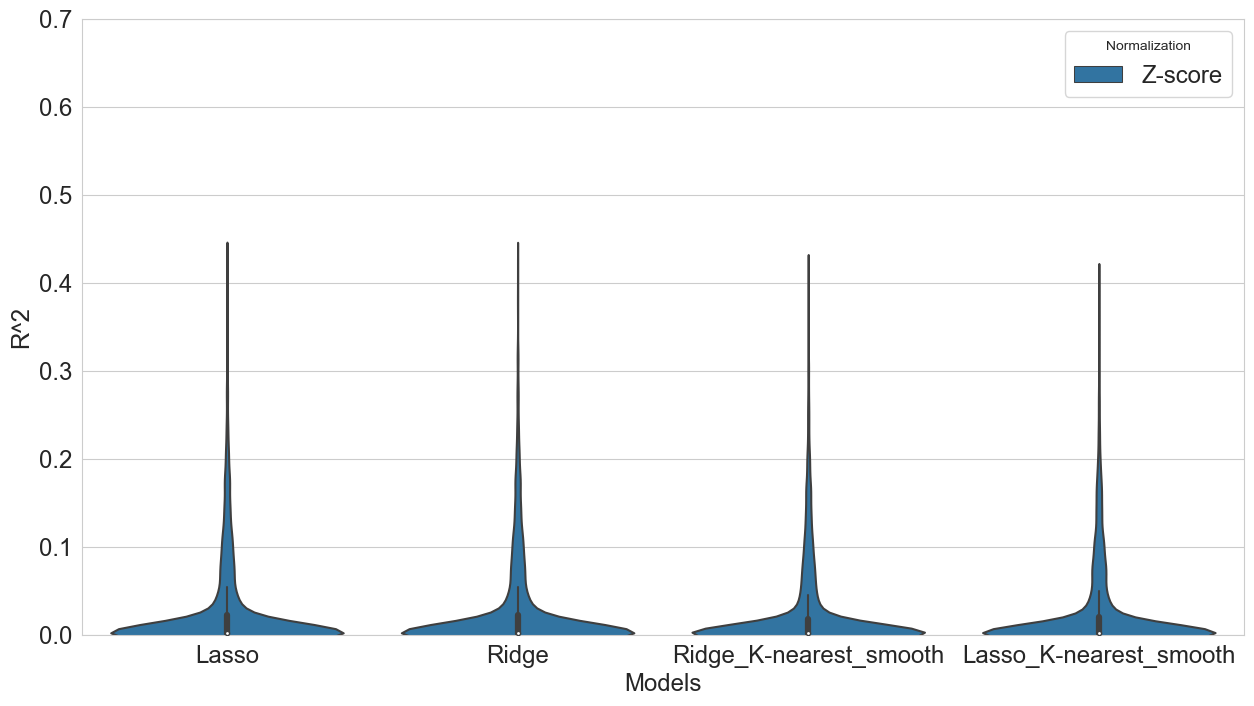

In [78]:


figures = plt.figure(figsize = (15,8))

#plot = sns.stripplot(x="Models", y='R^2', data=temp_df, size = 10, color = 'blue', alpha = 0.3)

#Hybrid_First = [mean_pluri, mean_meso, mean_cardio]
#error = [std_pluri, std_meso, std_pluri]
#plt.errorbar(range(3), Hybrid_First, yerr=error, capsize = 8, ecolor = 'grey', ls = 'none')
#ax = sns.boxplot(x="Models", y="R^2", data=temp_df)
ax = sns.violinplot(x="Models", y="R^2", data=temp_df,hue = 'Normalization')

ax.set(ylim=(0,0.7))

#x_pos = np.arange(len(conditions))
plt.savefig("Z_score Normalization")


In [79]:
df_smooth = pd.DataFrame(test_smooth, columns=['Models', 'R^2','Smoothed_test_and_val'])

[(0.0, 0.5)]

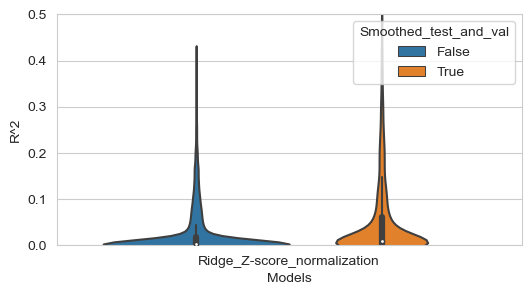

In [105]:
df_smooth = pd.DataFrame(test_smooth, columns=['Models', 'R^2','Smoothed_test_and_val'])
figures = plt.figure(figsize = (6,3))

#plot = sns.stripplot(x="Models", y='R^2', data=temp_df, size = 10, color = 'blue', alpha = 0.3)

#Hybrid_First = [mean_pluri, mean_meso, mean_cardio]
#error = [std_pluri, std_meso, std_pluri]
#plt.errorbar(range(3), Hybrid_First, yerr=error, capsize = 8, ecolor = 'grey', ls = 'none')
#ax = sns.boxplot(x="Models", y="R^2", data=temp_df)
ax = sns.violinplot(x="Models", y="R^2", data=df_smooth ,hue = 'Smoothed_test_and_val')

ax.set(ylim=(0,0.5))

#x_pos = np.arange(len(conditions))


The second normalization method:




In [72]:
peak_log = pd.read_csv('log_read_depth_normalized_peak.csv')
expression_log = pd.read_csv('log_read_depth_normalized_expression_level.csv')

In [100]:
X_train, X_val, X_test, y_train, y_val, y_test = sample_split(expression_log,peak_log, 11898)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [9519] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


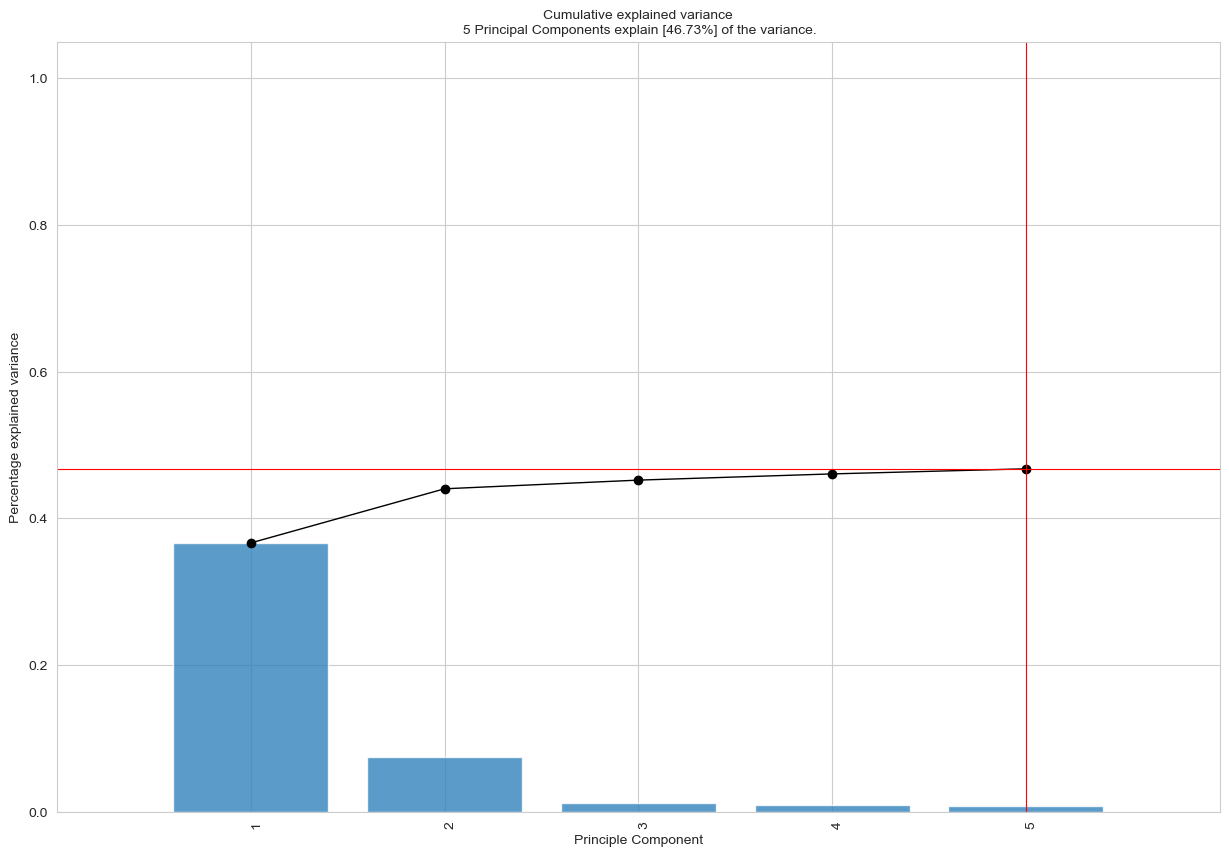

Finished 1000
Finished 2000
Finished 3000
Finished 4000
Finished 5000
Finished 6000
Finished 7000
Finished 8000
Finished 9000


<Figure size 1500x500 with 0 Axes>

In [106]:
X_train_smoothed = aggregate_smooth_function(y_train, X_train, components = 5,k= 30, fig_name = 'PCA_result_2.png')

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [1190] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


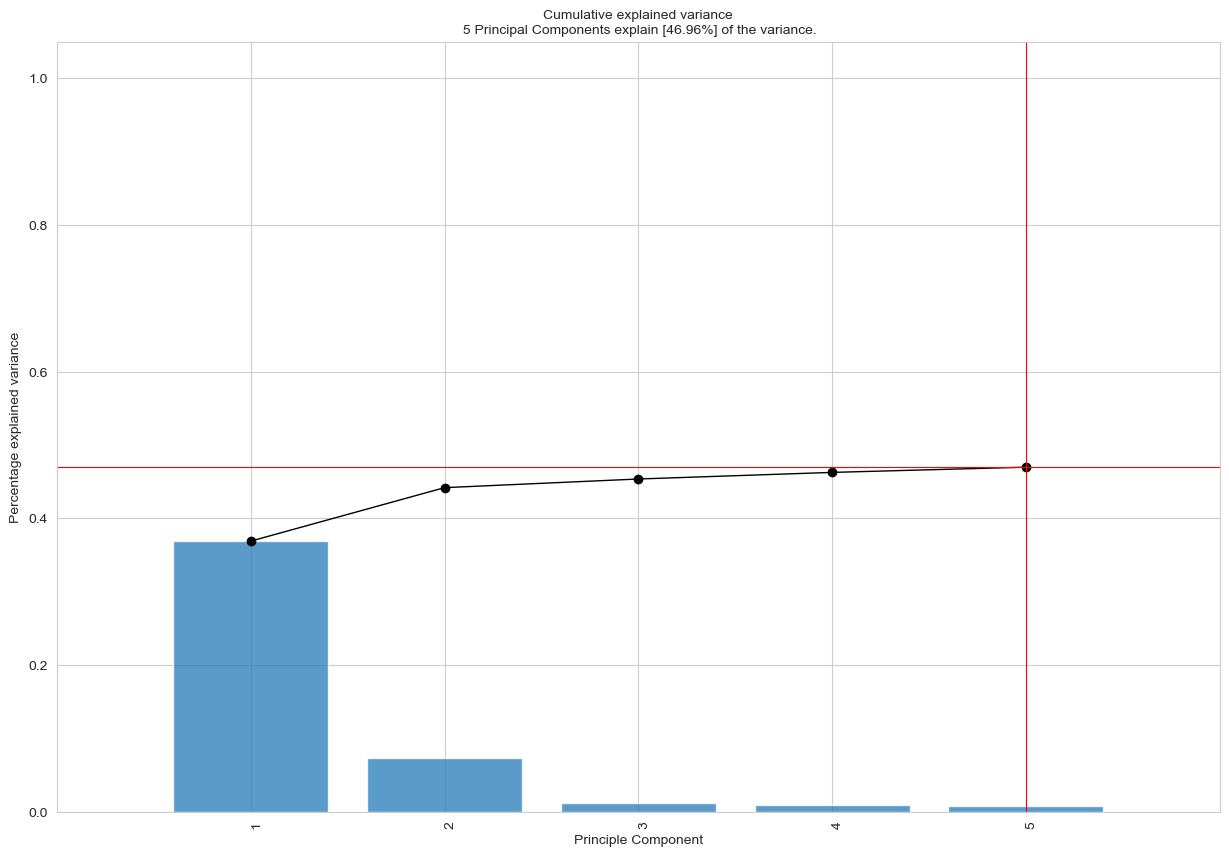

Finished 1000
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [1189] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


<Figure size 1500x500 with 0 Axes>

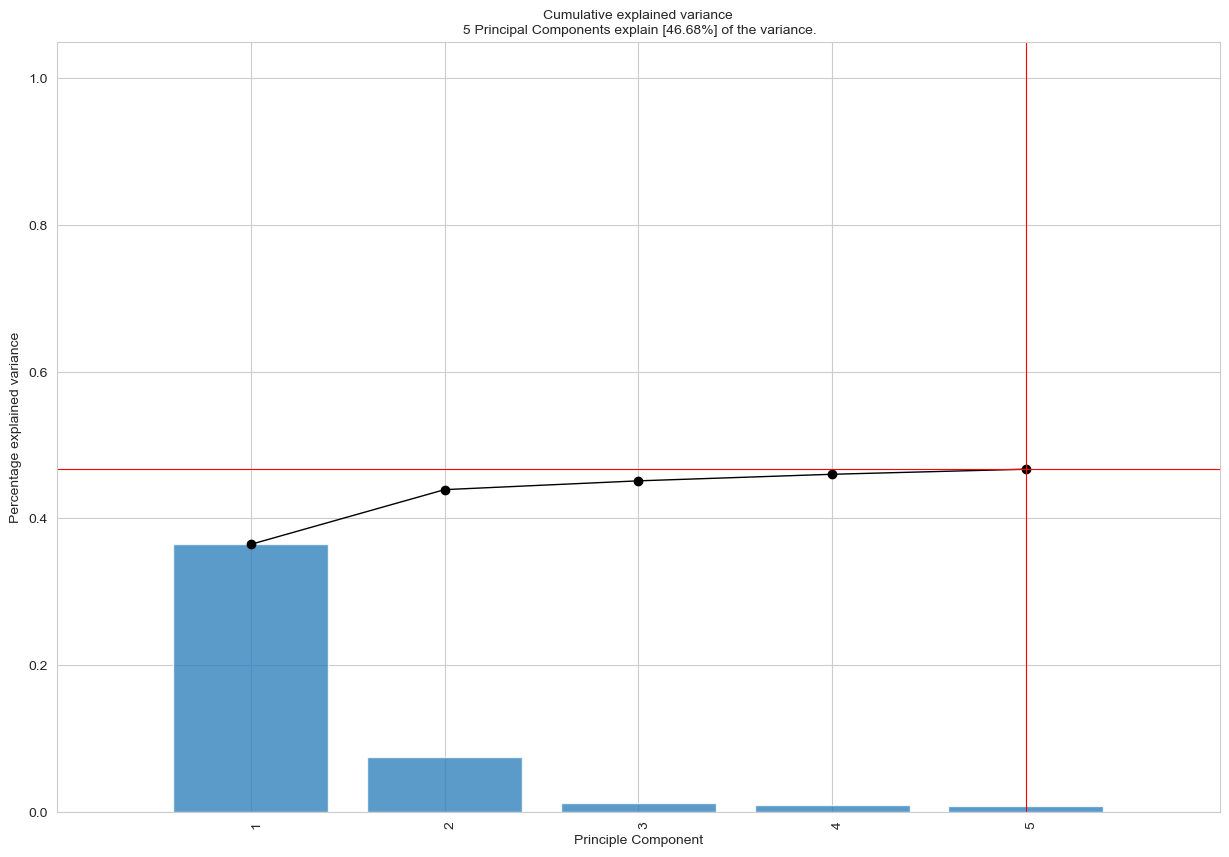

Finished 1000


<Figure size 1500x500 with 0 Axes>

In [107]:
X_val_smoothed = aggregate_smooth_function(y_val, X_val, components = 5,k= 30, fig_name = 'PCA_result.png')
X_test_smoothed = aggregate_smooth_function(y_test, X_test, components = 5,k= 30, fig_name = 'PCA_result.png')


In [153]:
#calculation ridge for smoothed X_train 
R_2_smooth_ridge = []
possibility_smooth_ridge = []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
Peaks = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if X_train_i.shape[1]== 0:
        continue
        
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        Peaks += [int(X_train_i.shape[1])]
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_ridge += [R**2]
        possibility_smooth_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]

In [169]:
X_train

,chromosome,length,avg_position,GGATGGCCACCTCAGG-1,TTGTCCATCGAGCTAT-1,GGGAGTAGTCCTCCAA-1,AGCGCCTAGTCATTTC-1,TCATAACCAAGTGTCC-1,GAGCGATAGACAACAG-1,GCAATCTAGCGGGCAA-1,...,AAAGCCCGTGGAAGGC-1,CTTCAGGAGTCTTGAA-1,GGTAACCGTCTTACTA-1,CATAGGTTCATTACAG-1,TGTAAGCTCGCACAAT-1,TTATTGCTCGCAAACT-1,GTAAGCTTCAGGCCTA-1,GGCTAGACAAAGCTAA-1,GTGTCCAAGTCATTGA-1,TGAGCTTAGGCTGTCA-1
0,chr1,997,634079,0.9582,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,chr1,917,778742,0.9582,1.4969,0.0000,0.0000,1.5735,0.8695,1.5806,...,0.0000,1.0769,1.0646,0.0000,1.4809,0.9856,0.0000,0.0000,1.5731,0.9444
2,chr1,883,827508,0.9582,0.0000,0.0000,0.9991,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.0646,1.0140,0.0000,0.0000,0.0000,1.1535,0.8215,0.9444
3,chr1,904,869924,0.9582,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4928,0.0000
4,chr1,859,904771,0.9582,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.9122,0.0000,0.0000,0.0000,0.9927,0.0000,0.0000,0.0000,0.4928,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20355,GL000195.1,849,32630,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4928,0.0000
20356,GL000219.1,900,40383,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0747,...,1.3568,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
20357,GL000219.1,891,42609,0.0000,0.0000,1.7083,0.0000,0.0000,0.8695,1.0747,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
20358,GL000219.1,907,99709,2.6851,0.0000,1.1817,1.2736,1.5735,0.8695,1.0747,...,0.0000,1.9179,1.9020,1.8357,0.0000,1.4722,1.1533,1.1535,0.4928,0.9444


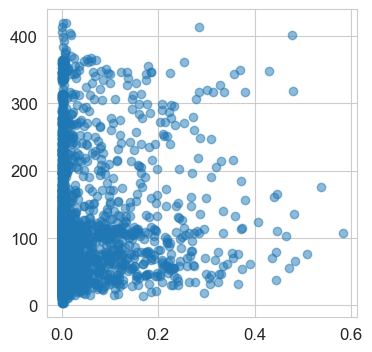

In [167]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.scatter(R_2_smooth_ridge, Peaks, alpha=0.5)

In [156]:
rows = []
for i in Peaks:
    rows += [[i, 'Peaks_number']]

df_peak_num = pd.DataFrame(rows, columns=['Number of peaks', 'Peak'])

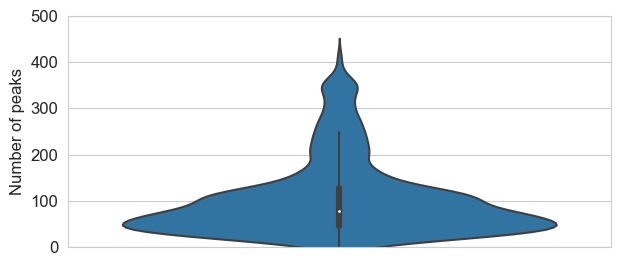

In [166]:
figures = plt.figure(figsize = (7,3))

#plot = sns.stripplot(x="Models", y='R^2', data=temp_df, size = 10, color = 'blue', alpha = 0.3)

#Hybrid_First = [mean_pluri, mean_meso, mean_cardio]
#error = [std_pluri, std_meso, std_pluri]
#plt.errorbar(range(3), Hybrid_First, yerr=error, capsize = 8, ecolor = 'grey', ls = 'none')
ax = sns.violinplot(y="Number of peaks", x="Peak", data=df_peak_num )

ax.set(ylim=(0,500))
ax.get_xaxis().set_visible(False)

plt.savefig("Number of peaks")


In [155]:
sum(R_2_smooth_ridge)/len(R_2_smooth_ridge)

0.03171395092837175

In [110]:
#calculation lasso for smoothed X_train
R_2_smooth_lasso = []
possibility_smooth_lasso = []
All_beta_smooth_lasso = []
RMSE_values_smooth_lasso = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if X_train_i.shape[1]== 0:
        continue
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_lasso += [R**2]
        possibility_smooth_lasso += [p]
        All_beta_smooth_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_lasso += [RMSE]



In [111]:
#calculation ridge for X_train
R_2_ridge = []
possibility_ridge = []
All_beta_ridge = []
RMSE_values_ridge = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if X_train_i.shape[1]== 0:
        continue
        
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_ridge += [R**2]
        possibility_ridge += [p]
        All_beta_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_ridge += [RMSE]

In [112]:
#calculation lasso for X_train
R_2_lasso = []
possibility_lasso = []
All_beta_lasso = []
RMSE_values_lasso = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if X_train_i.shape[1]== 0:
        continue
    
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_lasso += [R**2]
        possibility_lasso += [p]
        All_beta_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_lasso += [RMSE]

In [113]:
# calculate the effect of smoothed test and val 
R_2_smooth_test_ridge = []
possibility_smooth_test_ridge = []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
peak_count = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val_smoothed,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test_smoothed,5000000)
    peak_count += [X_train_i.shape[1]]
    
    if X_train_i.shape[1]== 0:
        continue
        
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 150, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True and torch.sum(torch.abs(X_test_i @ beta)) < (10**6) :#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_test_ridge += [R**2]
        
        possibility_smooth_test_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]

In [114]:
temp_df_rows_2 = []
for i in R_2_lasso:
    temp_df_rows_2 += [['Lasso', i, 'Log']]
for i in R_2_ridge:
    temp_df_rows_2 += [['Ridge', i, 'Log']]
for i in R_2_smooth_ridge:
    temp_df_rows_2 += [['Ridge_K-nearest_smooth', i, 'Log']]
    test_smooth += [['Ridge_log_normalization', i , 'False']]
for i in R_2_smooth_lasso:
    temp_df_rows_2 += [['Lasso_K-nearest_smooth', i, 'Log']]
for i in R_2_smooth_test_ridge:
    test_smooth += [['Ridge_log_normalization', i , 'True']]

temp_df_2 = pd.DataFrame(temp_df_rows_2, columns=['Models', 'R^2','Normalization'])

In [115]:
frames = [temp_df, temp_df_2]

result = pd.concat(frames)

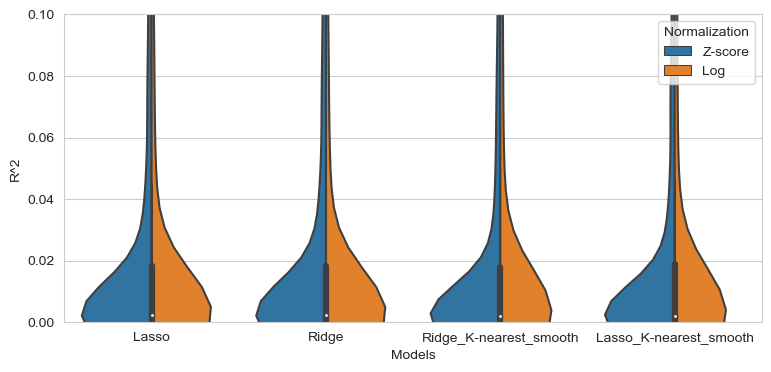

In [147]:
figures = plt.figure(figsize = (9,4))

#plot = sns.stripplot(x="Models", y='R^2', data=temp_df, size = 10, color = 'blue', alpha = 0.3)

#Hybrid_First = [mean_pluri, mean_meso, mean_cardio]
#error = [std_pluri, std_meso, std_pluri]
#plt.errorbar(range(3), Hybrid_First, yerr=error, capsize = 8, ecolor = 'grey', ls = 'none')
ax = sns.violinplot(x="Models", y="R^2", data=result,hue = 'Normalization', split=True)

ax.set(ylim=(0,0.10))


plt.savefig("Compare_Normalization")


In [176]:
test_smooth
for i in test_smooth:
    if i[2] == 'training Samples':
        i[2] = 'Training Samples'
    if i[2] == True:
        i[2] = "All Samples"

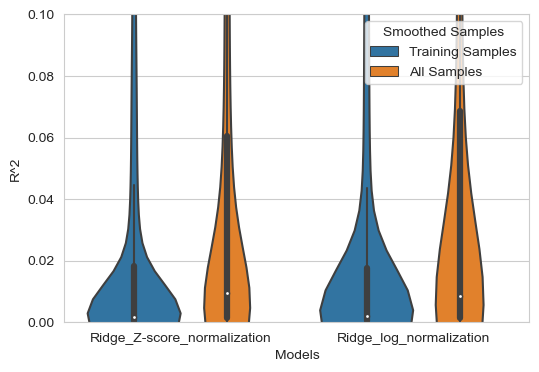

In [177]:
df_smooth = pd.DataFrame(test_smooth, columns=['Models', 'R^2','Smoothed Samples'])
figures = plt.figure(figsize = (6,4))

#plot = sns.stripplot(x="Models", y='R^2', data=temp_df, size = 10, color = 'blue', alpha = 0.3)

#Hybrid_First = [mean_pluri, mean_meso, mean_cardio]
#error = [std_pluri, std_meso, std_pluri]
#plt.errorbar(range(3), Hybrid_First, yerr=error, capsize = 8, ecolor = 'grey', ls = 'none')
#ax = sns.boxplot(x="Models", y="R^2", data=temp_df)
ax = sns.violinplot(x="Models", y="R^2", data=df_smooth ,hue = 'Smoothed Samples')

ax.set(ylim=(0,0.1))

#x_pos = np.arange(len(conditions))
plt.savefig("Figure 3111")


In [138]:
# read in the unnormalize values


peak_unnorm = pd.read_csv('reduced_peak.csv')
expression_unnorm = pd.read_csv('reduced_expression_level.csv')


In [139]:
peak_unnorm = peak_unnorm.iloc[:,3:]
expression_unnorm = expression_unnorm.iloc[:,4:]

In [140]:
x_list = list(peak_unnorm.sum(0))
y_list = list(expression_unnorm.sum(0))

In [141]:
for i in range(len(x_list)):
    x_list[i] = math.log(x_list[i])
for i in range(len(y_list)):
    y_list[i] = math.log(y_list[i])

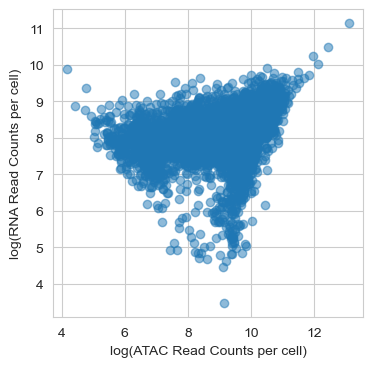

In [144]:

fig, ax = plt.subplots(figsize = (4, 4))
ax.scatter(x_list, y_list, alpha=0.5)
plt.xlabel("log(ATAC Read Counts per cell)")
plt.ylabel("log(RNA Read Counts per cell)")
plt.savefig("Scatter_of_distribution")

#b, a = np.polyfit(x_list, y_list, deg=1)
#xseq = np.linspace(3, 14, num=14)
#ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

plt.savefig("Scatter_plot")

After this lines, the rest will be some draft

In [81]:
device = "cuda"

In [37]:
R_2

[0.00021620509504128167,
 0.02458033136177097,
 0.010276653761703912,
 0.002353880352166004,
 0.00045987722728317647,
 0.04389017418129183,
 0.028452728481905405,
 0.005178914369470583]

In [461]:
#All_beta

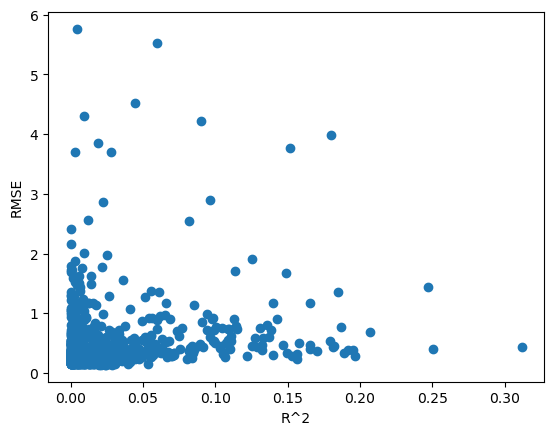

In [54]:
plt.scatter(R_2, RMSE_values)
#plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("R^2")
plt.ylabel("RMSE")
plt.savefig("normalized_ridge")
plt.show()


In [415]:
N = len(y)
print(N)
np.random.seed(123) # for reproducibility
rand_perm = np.random.permutation(N)
train_idx = rand_perm[:int(np.ceil(0.8 * N))]
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))]
test_idx = rand_perm[int(np.ceil(0.9 * N)):]

X_train = x[train_idx,:]
X_val = x[val_idx,:]
X_test = x[test_idx,:]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]
print(len(y_val))

rand_perm[:10]

3233
323


array([1287,  112,  227, 1531, 2671,  690, 1039,  481, 1466, 3070])

Lambda=0.000001, fitting...
Lambda=0.000010, fitting...
Lambda=0.000100, fitting...
Lambda=0.001000, fitting...
Lambda=0.010000, fitting...
Lambda=0.100000, fitting...


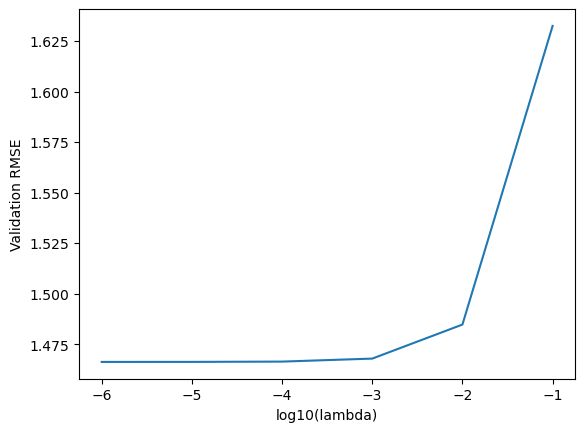

In [416]:
lambdas = 10.**torch.arange(-6,0,step=1,dtype=torch.float)
val_rmse = np.zeros(len(lambdas))
learning_rate = 0.001
for lbd_idx,lamb in enumerate(lambdas): 
    print("Lambda=%f, fitting..." % lamb) 
    beta, _ = fit_lasso(X_train, y_train, lamb, distant, learning_rate = learning_rate)
    pred_val = X_val @ beta # make predictions on the validation set
    val_rmse[lbd_idx] = np.sqrt(torch.mean((y_val - pred_val)**2).item()) # item() gets the scalar value
_ = plt.plot(np.log10(lambdas.numpy()), val_rmse)
_ = plt.xlabel("log10(lambda)")
_ = plt.ylabel("Validation RMSE")

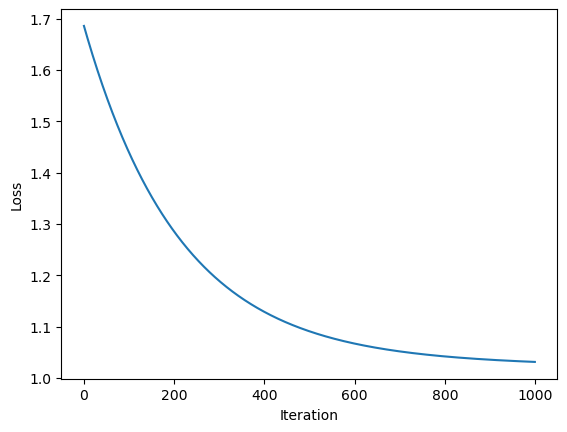

In [417]:
beta,losses = fit_lasso(X_train, y_train, distants = distant, lamb = 0.002, iterations = 1000, learning_rate = 0.0001)
_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")




In [419]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [2., 0., 0.,  ..., 0., 2., 4.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [3., 3., 0.,  ..., 0., 0., 0.]])

In [420]:
y

tensor([1., 0., 1.,  ..., 0., 0., 0.])

In [421]:
#distant

In [422]:
#beta

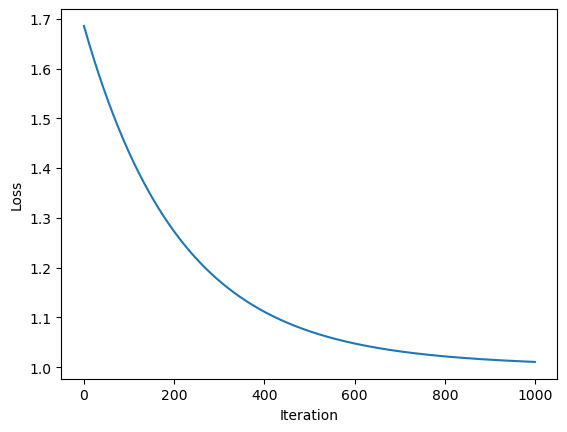

In [423]:
beta,losses = ridge_regression_gd(X_train, y_train, distants = distant, lamb = 0.002, iterations = 1000, learning_rate = 0.0001)
_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")




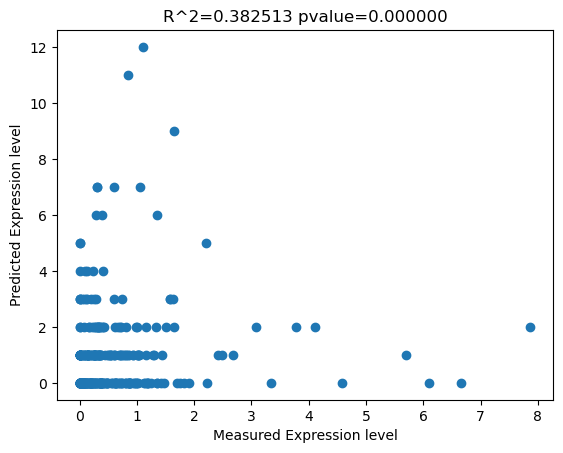

In [424]:
pred_test = X_test @ beta # make predictions on the test set
R,p = scipy.stats.pearsonr(y_test, pred_test)
plt.scatter(pred_test, y_val)
plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("Measured Expression level")
plt.ylabel("Predicted Expression level")
plt.show()

In [182]:
interval = 5000000
N = 3233
np.random.seed(123) # for reproducibility
rand_perm = np.random.permutation(N)
train_idx = rand_perm[:int(np.ceil(0.8 * N))]
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))]
test_idx = rand_perm[int(np.ceil(0.9 * N)):]


R_2 = []
possibility = []
All_beta = []
RMSE_values = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    gene = expression[expression['feature_id'] == feature_id]
    TSS = int(gene['TSS'])
    y = gene.iloc[:,4:]
    y = torch.from_numpy(y.values).float()
    y = torch.transpose(y, 0, 1)
    y = y[:,0]

    peaks = peak[(peak['chromosome'] == current_chr) & (peak['avg_position'] >= (TSS-interval)) & (peak['avg_position'] <= (TSS+interval))].copy()
    peaks['distant'] = abs(peaks['avg_position'] - TSS) + 2
    x = peaks.iloc[:,3:-1]
    x = torch.from_numpy(x.values).float()
    x = torch.transpose(x, 0, 1)
    distant = torch.from_numpy(peaks['distant'].values).float()
    distant = torch.log(distant)


    X_train = x[train_idx,:]
    X_val = x[val_idx,:]
    X_test = x[test_idx,:]

    y_train = y[train_idx]
    y_val = y[val_idx]
    y_test = y[test_idx]

    rand_perm[:10]
    
    
    beta = ridge_regression(X_train, y_train, lamb = 0.0001, distants = distant )
    if len(beta) != 0 and torch.isnan(beta)[0] != True:
        pred_test = X_test @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test, pred_test)
        R_2 += [R**2]
        possibility += [p]
        All_beta += [beta]
        MSE = mean_squared_error(y_test, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values += [RMSE]


In [182]:
peak = pd.read_csv('normalize_peak.csv')
expression = pd.read_csv('normalize_expression_level.csv')
X_train, X_val, X_test, y_train, y_val, y_test = sample_split(expression,peak, 3233)


[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [2587] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


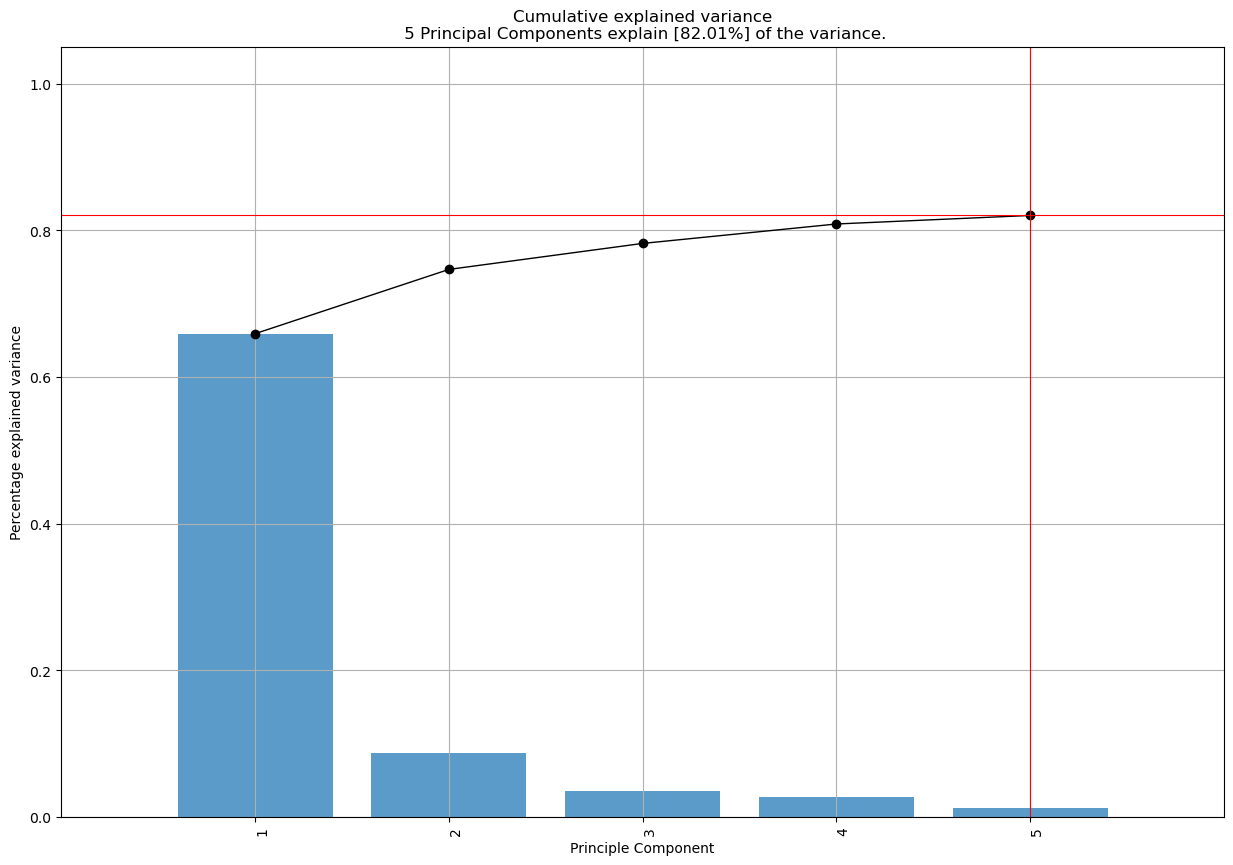

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [323] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


<Figure size 640x480 with 0 Axes>

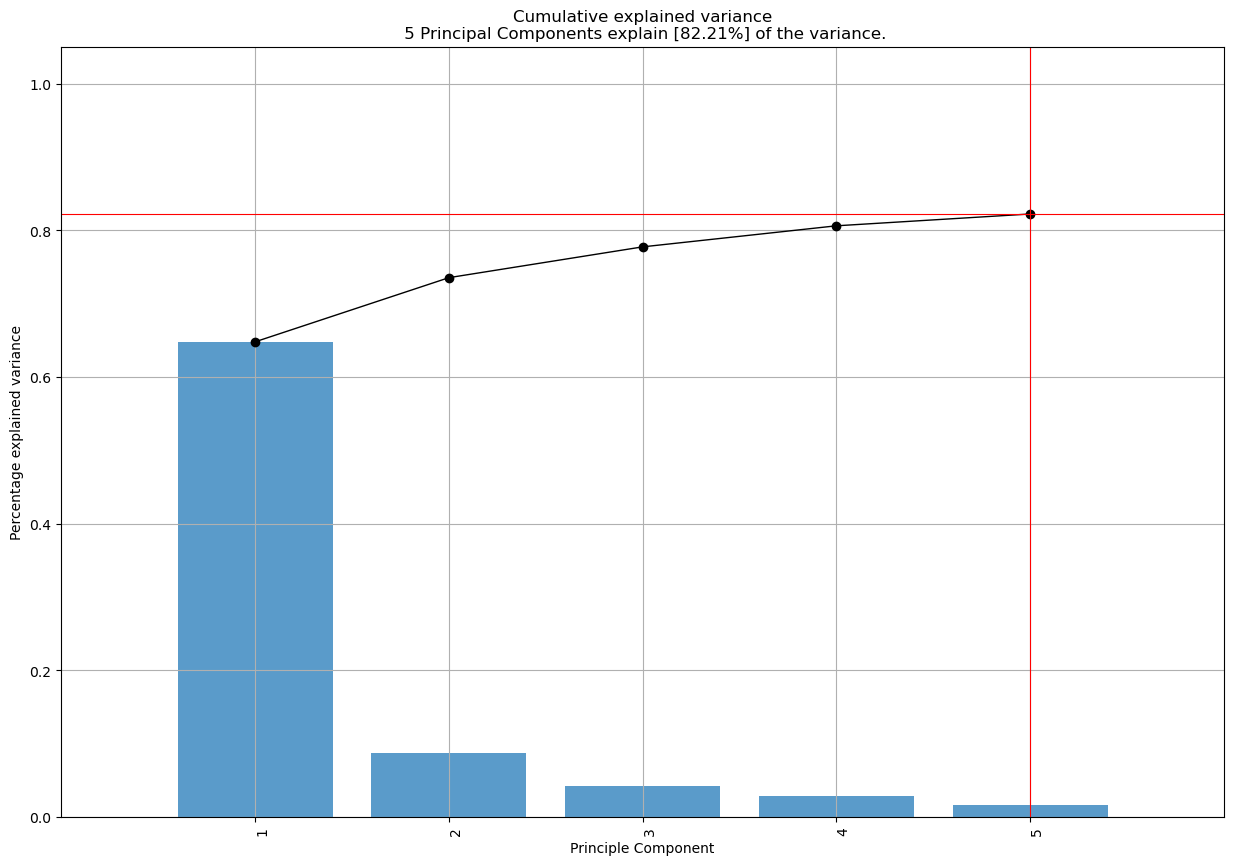

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [323] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


<Figure size 640x480 with 0 Axes>

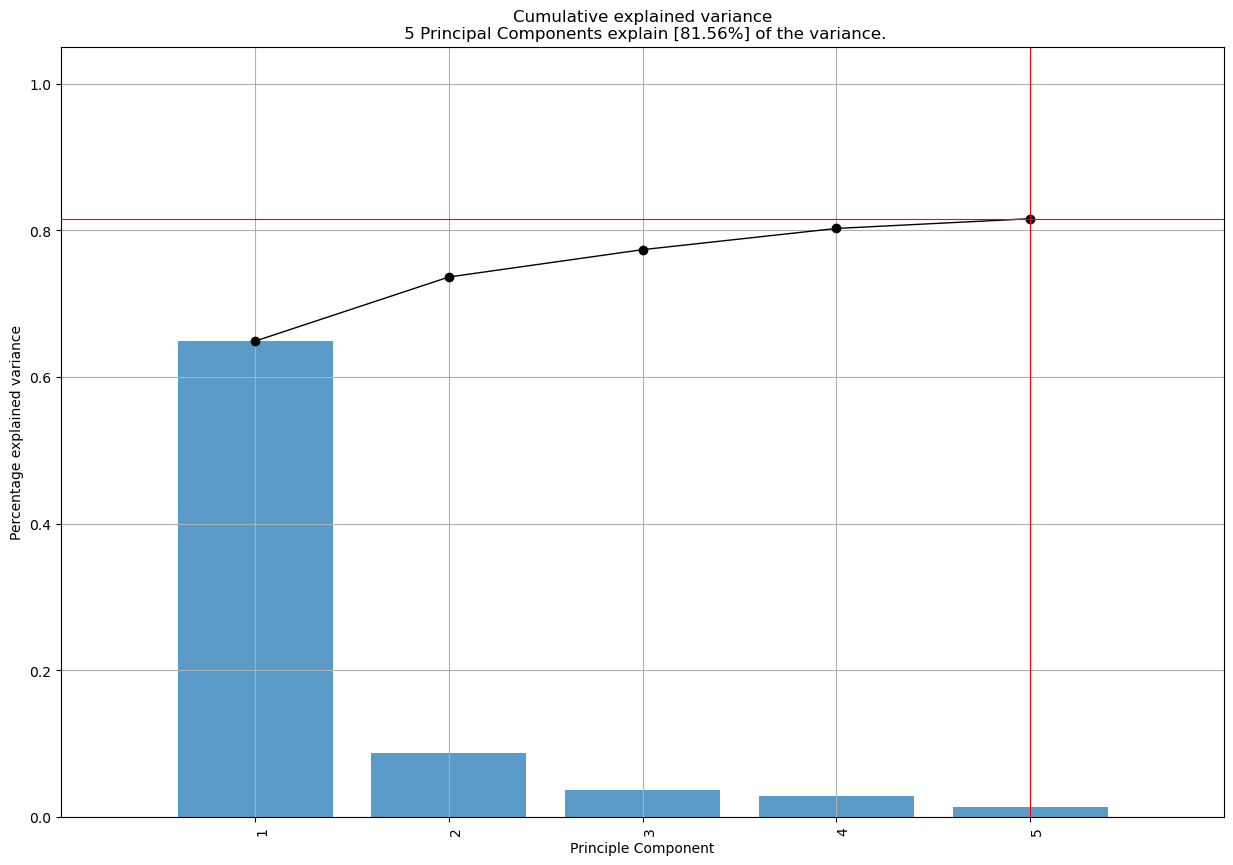

<Figure size 640x480 with 0 Axes>

In [183]:
X_train_smoothed = aggregate_smooth_function(y_train, X_train, components = 5,k= 30, fig_name = 'PCA_result.png')
X_val_smoothed = aggregate_smooth_function(y_val, X_val, components = 5,k= 30, fig_name = 'PCA_result.png')
X_test_smoothed = aggregate_smooth_function(y_test, X_test, components = 5,k= 30, fig_name = 'PCA_result.png')



In [49]:
#calculation ridge for smoothed X_train 
K_R_2_smooth_ridge = []
possibility_smooth_ridge = []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
peak_count = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val_smoothed,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test_smoothed,5000000)
    
    if len(X_train_i)== 0:
        continue
    peak_count += [X_train_i.shape[1]]
    
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        K_R_2_smooth_ridge += [R**2]
        possibility_smooth_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]

KeyboardInterrupt: 

In [34]:
len(K_R_2_smooth_ridge)

76

In [35]:
sum(R_2_smooth_ridge)/len(R_2_smooth_ridge)

0.0438428869108111

In [30]:
sum(peak_count)/len(peak_count)

9519.0

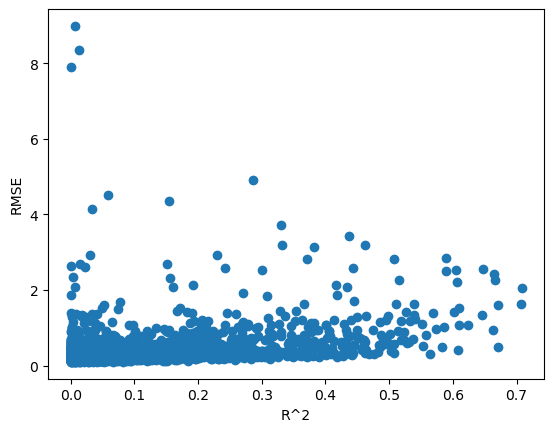

In [185]:
plt.scatter(R_2_smooth_ridge, RMSE_values_smooth_ridge)
#plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("R^2")
plt.ylabel("RMSE")
plt.savefig("smooth_all_ridge")
plt.show()




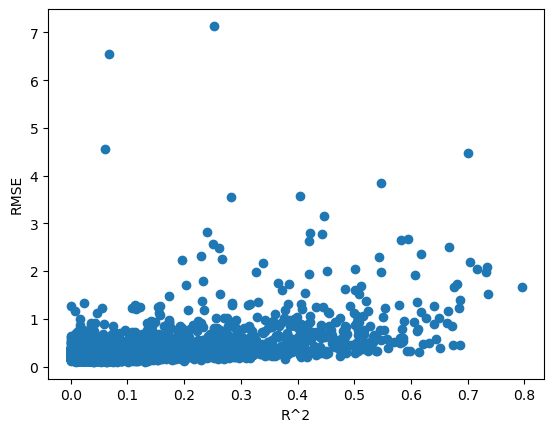

In [184]:
plt.scatter(R_2, RMSE_values)
#plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("R^2")
plt.ylabel("RMSE")
plt.savefig("smooth_all_ridge")
plt.show()
